In [ ]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path
%matplotlib inline
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims

## Read all images

In [ ]:
expdir='/Volumes/ukps-all$/user/tdanko/Students/hannah slices/TNR brain slices/'
protein="TNR" #TNR,Agg,WFA,HABP

In [9]:
results = {"filename":[],
          "exp condition":[],
          "ecmchannelno":[],
          "endosomechannelno":[],
           "Manual ecm spots mask":[],
           "Manual endosome spots mask":[],
          }
           
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):

    if filelist[i].endswith(".tif"): 
        if str(filelist[i][:-12]) not in str(results["filename"]):
            results["filename"].append(filelist[i][:-12])
            results["exp condition"].append(filelist[i][:-12].split('/')[-2])
            results["ecmchannelno"].append(1)
            results["endosomechannelno"].append(2)


## Load masks

In [10]:
for i in range(0,len(results["filename"])):
    results["Manual ecm spots mask"].append(np.load(results["filename"][i]+'_ecm_spots_mask_conservative.npy'))
for i in range(0,len(results["filename"])):
    results["Manual endosome spots mask"].append(np.load(results["filename"][i]+'_endosome_spots_mask_conservative.npy'))

In [11]:
results["Manual ecm spots mask"]

[array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

## Random image

Image name: Hippocampus_TNR_Caveolin_Series9_z
Experimental condition: Hippocampus_TNR_Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


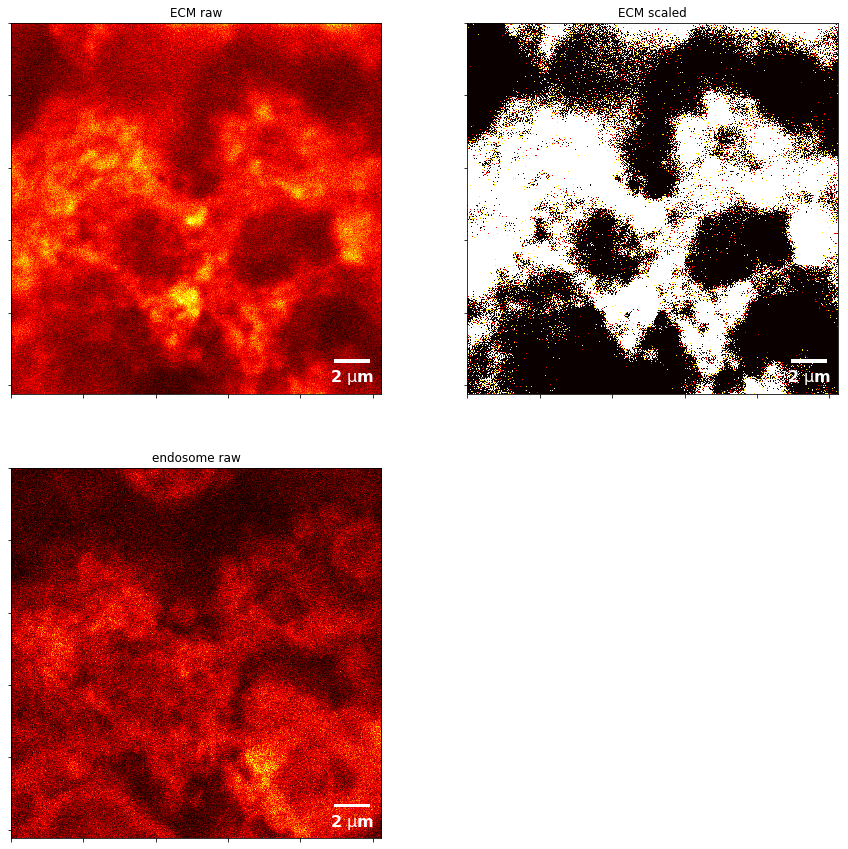

In [12]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
endosome_channel_no=results["endosomechannelno"][randomno]

ecm_image_name=results["filename"][randomno]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
endosome_image_name=results["filename"][randomno]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"

print("Image name:",results["filename"][randomno].split('/')[-1])
print("Experimental condition:",results["exp condition"][randomno])
ecm_image=pims.open(ecm_image_name)[0]
endosome_image=pims.open(endosome_image_name)[0]
   
figure=plt.figure(figsize=(15,15))
figure.add_subplot(221)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
figure.add_subplot(222)
plt.imshow(ecm_image,interpolation='none',cmap='hot',vmin=3*np.min(ecm_image),vmax=0.4*np.max(ecm_image))
plt.title('ECM scaled')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    

plt.gca().add_artist(scalebar)
figure.add_subplot(223)
plt.imshow(endosome_image,interpolation='none',cmap='hot')
plt.title('endosome raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

In [13]:
df=pd.DataFrame(results)
df["Protein"]='None'
df.loc[df["filename"].str.contains('Rab5'),'Protein']="Rab5"
df.loc[df["filename"].str.contains('Rab7'),'Protein']="Rab7"
df.loc[df["filename"].str.contains('Calreticulin'),'Protein']="Calreticulin"
df.loc[df["filename"].str.contains('Calnexin'),'Protein']="Calnexin"
df.loc[df["filename"].str.contains('Caveolin'),'Protein']="Caveolin"
df.loc[df["filename"].str.contains('Lamp1'),'Protein']="Lamp1"
df.loc[df["filename"].str.contains('TGN'),'Protein']="TGN"
df.loc[df["filename"].str.contains('unstained'),'Protein']="unstained"

In [14]:
df["Protein"].unique()

array(['Calreticulin', 'unstained', 'Lamp1', 'Calnexin', 'Rab5', 'Rab7',
       'Caveolin', 'TGN'], dtype=object)

## Look at an unstained image

Image name: Hippocampus_TNR_unstained_2_Series5_z
Experimental condition: Hippocampus_TNR_unstained_2


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Text(0.5, 1.0, 'endosome hist')

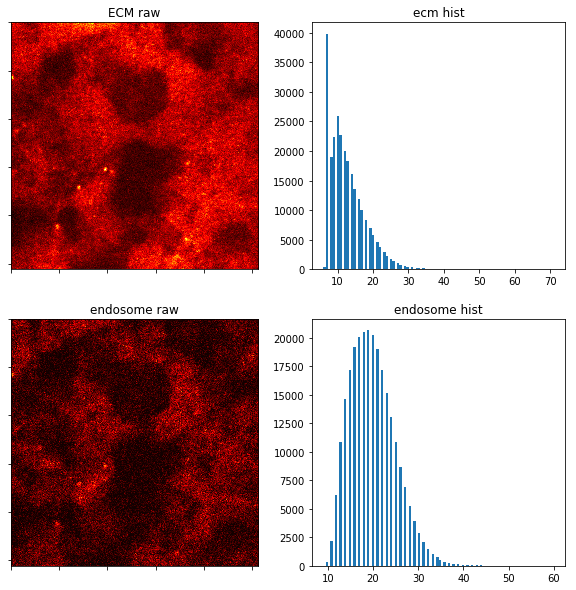

In [15]:
dfunstained=df[df["Protein"]=="unstained"]
dfunstained=dfunstained.reset_index(drop=True)

randomno=np.random.randint(1,len(dfunstained["filename"]))

ecm_image_name=dfunstained["filename"][randomno]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
endosome_image_name=dfunstained["filename"][randomno]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"

print("Image name:",results["filename"][randomno].split('/')[-1])
print("Experimental condition:",results["exp condition"][randomno])
ecm_image=pims.open(ecm_image_name)[0]
endosome_image=pims.open(endosome_image_name)[0]
   
figure=plt.figure(figsize=(10,10))
figure.add_subplot(221)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)

figure.add_subplot(223)
plt.imshow(endosome_image,interpolation='none',cmap='hot')
plt.title('endosome raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)

figure.add_subplot(222)
plt.hist(endosome_image.ravel(),bins=100)
plt.title('ecm hist')

figure.add_subplot(224)
plt.hist(ecm_image.ravel(),bins=100)
plt.title('endosome hist')



In [21]:
threshold_ecm=0.
threshold_endosome=0.

for image in range(0,len(dfunstained["filename"])):
    
    ecm_image_name=dfunstained["filename"][image]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
    endosome_image_name=dfunstained["filename"][image]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"


    ecm_image=pims.open(ecm_image_name)[0]
    endosome_image=pims.open(endosome_image_name)[0]
    
    ecm_image=ndi.median_filter(ecm_image,size=5)
    endosome_image=ndi.median_filter(endosome_image,size=5)
                   
    threshold_ecm+=(np.mean(ecm_image)+3*np.std(ecm_image))
    threshold_endosome+=(np.mean(endosome_image)+3*np.std(endosome_image))

threshold_ecm=threshold_ecm/len(dfunstained["filename"])
threshold_endosome=threshold_endosome/len(dfunstained["filename"])

print('threshold ecm: '+str(threshold_ecm))
print('threshold endosome: '+str(threshold_endosome))


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ ser

threshold ecm: 29.98750712847823
threshold endosome: 18.127737326823294


## Example of thresholded images

In [ ]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
endosome_channel_no=results["endosomechannelno"][randomno]

ecm_image_name=results["filename"][randomno]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
endosome_image_name=results["filename"][randomno]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"

print("Image name:",results["filename"][randomno].split('/')[-1])
print("Experimental condition:",results["exp condition"][randomno])
ecm_image=pims.open(ecm_image_name)[0]
endosome_image=pims.open(endosome_image_name)[0]

figure=plt.figure(figsize=(10,10))
figure.add_subplot(221)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)


figure.add_subplot(222)
plt.imshow(endosome_image,interpolation='none',cmap='hot')
plt.title('endosome raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)


ecm_image[ecm_image<threshold_ecm]=0
endosome_image[endosome_image<threshold_endosome]=0
   
figure=plt.figure(figsize=(10,10))
figure.add_subplot(223)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)


figure.add_subplot(224)
plt.imshow(endosome_image,interpolation='none',cmap='hot')
plt.title('endosome raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)


## Example of thresholded + median filtered images

In [ ]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
endosome_channel_no=results["endosomechannelno"][randomno]

ecm_image_name=results["filename"][randomno]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
endosome_image_name=results["filename"][randomno]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"

print("Image name:",results["filename"][randomno].split('/')[-1])
print("Experimental condition:",results["exp condition"][randomno])
ecm_image=pims.open(ecm_image_name)[0]
endosome_image=pims.open(endosome_image_name)[0]

ecm_image=ndi.median_filter(ecm_image,size=5)
endosome_image=ndi.median_filter(endosome_image,size=5)


figure=plt.figure(figsize=(10,10))
figure.add_subplot(221)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)


figure.add_subplot(222)
plt.imshow(endosome_image,interpolation='none',cmap='hot')
plt.title('endosome raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)


ecm_image[ecm_image<threshold_ecm]=0
endosome_image[endosome_image<threshold_endosome]=0
   
figure=plt.figure(figsize=(10,10))
figure.add_subplot(223)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)


figure.add_subplot(224)
plt.imshow(endosome_image,interpolation='none',cmap='hot')
plt.title('endosome raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)



## Measure coloc
- Threshold each channel
- Binarize and make into mask
- Find overlapping areas between masks --> new mask
- Under overlap mask: sum pixel intensities in ecm, sum pixel intensities in endosome 

In [ ]:
df["ECM summed intensity under overlap"]=np.nan
df["endosome summed intensity under overlap"]=np.nan
df["ecm+endosome summed intensity under overlap"]=np.nan
df["percent ecm overlap"]=np.nan
df["percent endosome overlap"]=np.nan



for image in range(0,len(df)):
    ecm_image_name=df["filename"][image]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
    endosome_image_name=df["filename"][image]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"

    print("Image name:",df["filename"][image].split('/')[-1])
    print("Experimental condition:",df["Protein"][image])

    ecm_image=pims.open(ecm_image_name)[0]
    endosome_image=pims.open(endosome_image_name)[0]

    ecm_image=ndi.median_filter(ecm_image,size=3)
    endosome_image=ndi.median_filter(endosome_image,size=3)
    
    ecm_image[ecm_image<threshold_ecm]=0
    endosome_image[endosome_image<threshold_endosome]=0
    
    mask_ecm=ecm_image>0
    mask_endosome=endosome_image>0
    mask_overlap=mask_ecm*mask_endosome
    
    ecm_int_under_overlap_mask=ecm_image[mask_overlap].sum()
    endosome_int_under_overlap_mask=endosome_image[mask_overlap].sum()
    
    ecm_intensity_under_ecm_mask=ecm_image[mask_ecm].sum()
    endosome_intensity_under_endosome_mask=endosome_image[mask_endosome].sum()
    
    df["ECM summed intensity under overlap"][image]=ecm_int_under_overlap_mask
    df["endosome summed intensity under overlap"][image]=endosome_int_under_overlap_mask
    df["ecm+endosome summed intensity under overlap"][image]=ecm_int_under_overlap_mask+endosome_int_under_overlap_mask
    
    df["percent ecm overlap"][image]=ecm_int_under_overlap_mask/ecm_intensity_under_ecm_mask
    df["percent endosome overlap"][image]=endosome_int_under_overlap_mask/endosome_intensity_under_endosome_mask

In [24]:
df2=deepcopy(df)
df2["ECM summed intensity under overlap"]=np.nan
df2["endosome summed intensity under overlap"]=np.nan
df2["ecm+endosome summed intensity under overlap"]=np.nan
df2["percent ecm overlap"]=np.nan
df2["percent endosome overlap"]=np.nan



for image in range(0,len(df2)):
    ecm_image_name=df2["filename"][image]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
    endosome_image_name=df2["filename"][image]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"

    print("Image name:",df2["filename"][image].split('/')[-1])
    print("Experimental condition:",df2["Protein"][image])

    ecm_image=pims.open(ecm_image_name)[0]
    endosome_image=pims.open(endosome_image_name)[0]

    ecm_image=ndi.median_filter(ecm_image,size=3)
    endosome_image=ndi.median_filter(endosome_image,size=3)
    
    
    mask_ecm=df2["Manual ecm spots mask"][image]
    mask_endosome=df2["Manual endosome spots mask"][image]
    mask_overlap=mask_ecm*mask_endosome
    
    ecm_int_under_overlap_mask=ecm_image[mask_overlap].sum()
    endosome_int_under_overlap_mask=endosome_image[mask_overlap].sum()
    
    ecm_intensity_under_ecm_mask=ecm_image[mask_ecm].sum()
    endosome_intensity_under_endosome_mask=endosome_image[mask_endosome].sum()
    
    df2["ECM summed intensity under overlap"][image]=ecm_int_under_overlap_mask
    df2["endosome summed intensity under overlap"][image]=endosome_int_under_overlap_mask
    df2["ecm+endosome summed intensity under overlap"][image]=ecm_int_under_overlap_mask+endosome_int_under_overlap_mask
    
    df2["percent ecm overlap"][image]=ecm_int_under_overlap_mask/ecm_intensity_under_ecm_mask
    df2["percent endosome overlap"][image]=endosome_int_under_overlap_mask/endosome_intensity_under_endosome_mask

Image name: Hippocampus_TNR_Calreticulin_Series9_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://p

Image name: Hippocampus_TNR_Calreticulin_Series8_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Calreticulin_Series7_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Calreticulin_Series6_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Calreticulin_Series5_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file


Image name: Hippocampus_TNR_Calreticulin_Series4_z
Experimental condition: Calreticulin


TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Calreticulin_Series3_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Calreticulin_Series2_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Calreticulin_Series1_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Calreticulin_Series10_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Calreticulin_Series0_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_unstained_2_Series6_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_2_Series5_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_2_Series4_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_2_Series3_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_2_Series2_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in ulong_scalars
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in ulong_scalars
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_2_Series1_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_2_Series0_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_Series6_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_Series5_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_Series4_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_Series3_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_Series2_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_Series1_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_Series0_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_2_Series6_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_2_Series5_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_2_Series4_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_2_Series3_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_2_Series2_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_2_Series1_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_2_Series0_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_Series6_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_Series5_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_Series4_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_Series3_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_Series2_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_Series1_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_Series0_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Calnexin_Series7_z
Experimental condition: Calnexin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Calnexin_Series6_z
Experimental condition: Calnexin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Calnexin_Series5_z
Experimental condition: Calnexin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Calnexin_Series4_z
Experimental condition: Calnexin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Calnexin_Series3_z
Experimental condition: Calnexin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Calnexin_Series2_z
Experimental condition: Calnexin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Calnexin_Series1_z
Experimental condition: Calnexin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Calnexin_Series0_z
Experimental condition: Calnexin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_2_Series6_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_2_Series5_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_2_Series4_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_2_Series3_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_2_Series2_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_2_Series1_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_2_Series0_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_2_Series6_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_2_Series5_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_2_Series4_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_2_Series3_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_2_Series2_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_2_Series1_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_2_Series0_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_2_Series6_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_2_Series5_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_2_Series4_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_2_Series3_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_2_Series2_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_2_Series1_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_2_Series0_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_Series7_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_Series6_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_Series5_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_Series4_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_Series3_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_Series2_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_Series1_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_Series0_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_Series6_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_Series5_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_Series4_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_Series3_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_Series2_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_Series1_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_Series0_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_Series8_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_Series7_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_Series6_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_Series5_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_Series4_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_Series3_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_Series2_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_Series1_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_Series0_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Caveolin_Series9_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series8_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series7_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series6_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series5_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series4_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series3_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series2_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series1_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series11_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series10_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series0_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_TGN38_Series9_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_TGN38_Series8_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_TGN38_Series7_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_TGN38_Series6_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_TGN38_Series5_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_TGN38_Series4_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_TGN38_Series3_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_TGN38_Series2_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_TGN38_Series1_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_TGN38_Series12_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_TGN38_Series11_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_TGN38_Series10_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_TGN38_Series0_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


## With thresholding

In [22]:
df["ECM summed intensity under overlap"]=np.nan
df["endosome summed intensity under overlap"]=np.nan
df["ecm+endosome summed intensity under overlap"]=np.nan
df["percent ecm overlap"]=np.nan
df["percent endosome overlap"]=np.nan



for image in range(0,len(df)):
    ecm_image_name=df["filename"][image]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
    endosome_image_name=df["filename"][image]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"

    print("Image name:",df["filename"][image].split('/')[-1])
    print("Experimental condition:",df["Protein"][image])

    ecm_image=pims.open(ecm_image_name)[0]
    endosome_image=pims.open(endosome_image_name)[0]

    ecm_image=ndi.median_filter(ecm_image,size=3)
    endosome_image=ndi.median_filter(endosome_image,size=3)
    
    ecm_image[ecm_image<threshold_ecm]=0
    endosome_image[endosome_image<threshold_endosome]=0
    
    mask_ecm=df["Manual ecm spots mask"][image]
    mask_endosome=df["Manual endosome spots mask"][image]
    mask_overlap=mask_ecm*mask_endosome
    
    ecm_int_under_overlap_mask=ecm_image[mask_overlap].sum()
    endosome_int_under_overlap_mask=endosome_image[mask_overlap].sum()
    
    ecm_intensity_under_ecm_mask=ecm_image[mask_ecm].sum()
    endosome_intensity_under_endosome_mask=endosome_image[mask_endosome].sum()
    
    df["ECM summed intensity under overlap"][image]=ecm_int_under_overlap_mask
    df["endosome summed intensity under overlap"][image]=endosome_int_under_overlap_mask
    df["ecm+endosome summed intensity under overlap"][image]=ecm_int_under_overlap_mask+endosome_int_under_overlap_mask
    
    df["percent ecm overlap"][image]=ecm_int_under_overlap_mask/ecm_intensity_under_ecm_mask
    df["percent endosome overlap"][image]=endosome_int_under_overlap_mask/endosome_intensity_under_endosome_mask

Image name: Hippocampus_TNR_Calreticulin_Series9_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://p

Image name: Hippocampus_TNR_Calreticulin_Series8_z
Experimental condition: Calreticulin


/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Calreticulin_Series7_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Calreticulin_Series6_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Calreticulin_Series5_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Calreticulin_Series4_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Calreticulin_Series3_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Calreticulin_Series2_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Calreticulin_Series1_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Calreticulin_Series10_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Calreticulin_Series0_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_unstained_2_Series6_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in ulong_scalars


Image name: Hippocampus_TNR_unstained_2_Series5_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_2_Series4_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_2_Series3_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_2_Series2_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in ulong_scalars


Image name: Hippocampus_TNR_unstained_2_Series1_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_2_Series0_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_Series6_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_Series5_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_Series4_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_Series3_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_Series2_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_Series1_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_Series0_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_2_Series6_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_2_Series5_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_2_Series4_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_2_Series3_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_2_Series2_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_2_Series1_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_2_Series0_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_Series6_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_Series5_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_Series4_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_Series3_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_Series2_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_Series1_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_Series0_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Calnexin_Series7_z
Experimental condition: Calnexin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Calnexin_Series6_z
Experimental condition: Calnexin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Calnexin_Series5_z
Experimental condition: Calnexin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Calnexin_Series4_z
Experimental condition: Calnexin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Calnexin_Series3_z
Experimental condition: Calnexin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Calnexin_Series2_z
Experimental condition: Calnexin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Calnexin_Series1_z
Experimental condition: Calnexin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Calnexin_Series0_z
Experimental condition: Calnexin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_2_Series6_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_2_Series5_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_2_Series4_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_2_Series3_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_2_Series2_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_2_Series1_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_2_Series0_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_2_Series6_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_2_Series5_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_2_Series4_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_2_Series3_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_2_Series2_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file


Image name: Hippocampus_TNR_Rab5_2_Series1_z
Experimental condition: Rab5


TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_2_Series0_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_2_Series6_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_2_Series5_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_2_Series4_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_2_Series3_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_2_Series2_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_2_Series1_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_2_Series0_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_Series7_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_Series6_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_Series5_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_Series4_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_Series3_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_Series2_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_Series1_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_Series0_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_Series6_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_Series5_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file


Image name: Hippocampus_TNR_unstained_Series4_z
Experimental condition: unstained


TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_Series3_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_Series2_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_Series1_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_Series0_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_Series8_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_Series7_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_Series6_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_Series5_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_Series4_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_Series3_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_Series2_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_Series1_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_Series0_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Caveolin_Series9_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series8_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series7_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series6_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series5_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series4_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series3_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series2_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series1_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series11_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series10_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series0_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_TGN38_Series9_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_TGN38_Series8_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_TGN38_Series7_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_TGN38_Series6_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_TGN38_Series5_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_TGN38_Series4_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_TGN38_Series3_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_TGN38_Series2_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_TGN38_Series1_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_TGN38_Series12_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_TGN38_Series11_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_TGN38_Series10_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_TGN38_Series0_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


'x1, x2 = 0,1\ny= 1.4\nh=0.02\ncol=\'black\'\nplt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)\nplt.text((x1+x2)*.5, y+h, "ns", ha=\'center\', va=\'bottom\', color=col,size=24, weight=\'bold\')\n\ndiri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"\nfig.savefig(diri+\'supp3_postsynpasesdio_mushstubby_alleps.svg\', bbox_inches=\'tight\', format=\'svg\')'

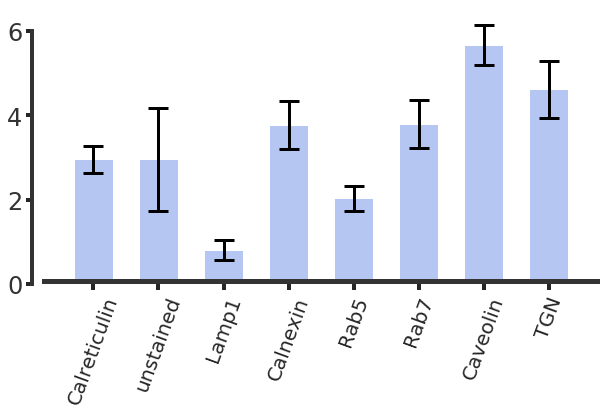

In [23]:
vari="percent ecm overlap"

sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker
plt.rcParams['font.sans-serif'] = 'Helvetica'

df2plot=df

fig=plt.figure(figsize=(10,5))
palette={"All, mushroom": "#adadad",
         "All, flat": "#adadad",
         "New, dmso, mushroom":"#adadad",
         "New, dmso, flat":"#adadad",
        "New, bic, mushroom":"#abc2fc",
         "New, bic, flat":"#abc2fc"}

order=df["Protein"].unique()

g=sns.barplot(data=df2plot,y=vari,x="Protein",
            color="#abc2fc",ci=None)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
change_width(g, .6)

plt.errorbar(x=np.arange(0,len(order)),
             y=[df2plot[df2plot["Protein"]==condtype][vari].mean() for condtype in order],
             yerr=[df2plot[df2plot["Protein"]==condtype][vari].sem() for condtype in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

#plt.ylim([0,1.5])
plt.axhline(0, color='#333333',alpha=1,linewidth=10)

scale_y=1/10
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
g.yaxis.set_major_formatter(ticks_y)
#plt.yticks([0,.5,1,1.5],color='#333333')
g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)
plt.rcParams['font.sans-serif'] = 'Helvetica'
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)
g.set_ylabel('')
g.set_xlabel('',color='#333333',alpha=.7)
plt.xticks(g.get_xticks(),
           rotation=70,size=20)
plt.yticks(g.get_yticks(),size=24,color='#333333')
g.grid(False)


'''x1, x2 = 0,1
y= 1.4
h=0.02
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=24, weight='bold')

diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'supp3_postsynpasesdio_mushstubby_alleps.svg', bbox_inches='tight', format='svg')'''

## without thresholding

'x1, x2 = 0,1\ny= 1.4\nh=0.02\ncol=\'black\'\nplt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)\nplt.text((x1+x2)*.5, y+h, "ns", ha=\'center\', va=\'bottom\', color=col,size=24, weight=\'bold\')\n\ndiri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"\nfig.savefig(diri+\'supp3_postsynpasesdio_mushstubby_alleps.svg\', bbox_inches=\'tight\', format=\'svg\')'

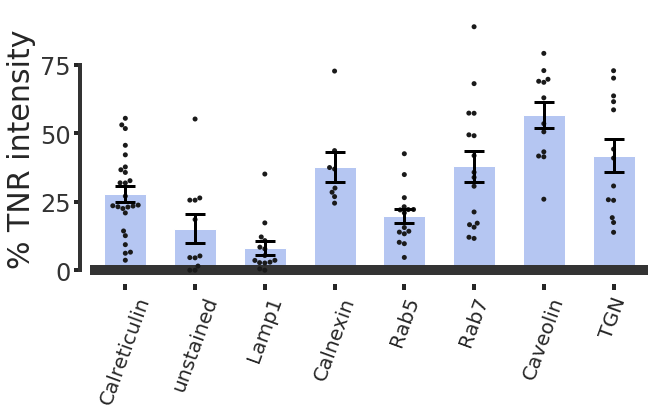

In [30]:
vari="percent ecm overlap"

sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker
plt.rcParams['font.sans-serif'] = 'Helvetica'

df2plot=df2

fig=plt.figure(figsize=(10,5))
palette={"All, mushroom": "#adadad",
         "All, flat": "#adadad",
         "New, dmso, mushroom":"#adadad",
         "New, dmso, flat":"#adadad",
        "New, bic, mushroom":"#abc2fc",
         "New, bic, flat":"#abc2fc"}

order=df2["Protein"].unique()

g=sns.barplot(data=df2plot,y=vari,x="Protein",
            color="#abc2fc",ci=None)

g=sns.swarmplot(data=df2plot,y=vari,x="Protein",
            color="k")

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
change_width(g, .6)

plt.errorbar(x=np.arange(0,len(order)),
             y=[df2plot[df2plot["Protein"]==condtype][vari].mean() for condtype in order],
             yerr=[df2plot[df2plot["Protein"]==condtype][vari].sem() for condtype in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

#plt.ylim([0,1.5])
plt.axhline(0, color='#333333',alpha=1,linewidth=10)

scale_y=1/100
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
g.yaxis.set_major_formatter(ticks_y)
#plt.yticks([0,.5,1,1.5],color='#333333')
g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)
plt.rcParams['font.sans-serif'] = 'Helvetica'
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)
g.set_ylabel('% TNR intensity')
g.set_xlabel('',color='#333333',alpha=.7)
plt.xticks(g.get_xticks(),
           rotation=70,size=20)
plt.yticks(g.get_yticks(),size=24,color='#333333')
g.grid(False)


'''x1, x2 = 0,1
y= 1.4
h=0.02
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=24, weight='bold')

diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'supp3_postsynpasesdio_mushstubby_alleps.svg', bbox_inches='tight', format='svg')'''

## individual bg removal

In [31]:
df3=deepcopy(df)
df3["ECM summed intensity under overlap"]=np.nan
df3["endosome summed intensity under overlap"]=np.nan
df3["ecm+endosome summed intensity under overlap"]=np.nan
df3["percent ecm overlap"]=np.nan
df3["percent endosome overlap"]=np.nan



for image in range(0,len(df3)):
    ecm_image_name=df3["filename"][image]+"0_ch"+str(ecm_channel_no-1)+"_t0.tif"
    endosome_image_name=df3["filename"][image]+"0_ch"+str(endosome_channel_no-1)+"_t0.tif"

    print("Image name:",df3["filename"][image].split('/')[-1])
    print("Experimental condition:",df3["Protein"][image])

    ecm_image=pims.open(ecm_image_name)[0]
    endosome_image=pims.open(endosome_image_name)[0]

    bg_ecm=ndi.median_filter(ecm_image,size=5)
    ecm_image=np.subtract(ecm_image,bg_ecm)
    ecm_image[ecm_image<0]=0
    
    bg_endosome=ndi.median_filter(endosome_image,size=5)
    endosome_image=np.subtract(endosome_image,bg_endosome)
    endosome_image[endosome_image<0]=0
    
    mask_ecm=df3["Manual ecm spots mask"][image]
    mask_endosome=df3["Manual endosome spots mask"][image]
    mask_overlap=mask_ecm*mask_endosome
    
    ecm_int_under_overlap_mask=ecm_image[mask_overlap].sum()
    endosome_int_under_overlap_mask=endosome_image[mask_overlap].sum()
    
    ecm_intensity_under_ecm_mask=ecm_image[mask_ecm].sum()
    endosome_intensity_under_endosome_mask=endosome_image[mask_endosome].sum()
    
    df3["ECM summed intensity under overlap"][image]=ecm_int_under_overlap_mask
    df3["endosome summed intensity under overlap"][image]=endosome_int_under_overlap_mask
    df3["ecm+endosome summed intensity under overlap"][image]=ecm_int_under_overlap_mask+endosome_int_under_overlap_mask
    
    df3["percent ecm overlap"][image]=ecm_int_under_overlap_mask/ecm_intensity_under_ecm_mask
    df3["percent endosome overlap"][image]=endosome_int_under_overlap_mask/endosome_intensity_under_endosome_mask

Image name: Hippocampus_TNR_Calreticulin_Series9_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://p

Image name: Hippocampus_TNR_Calreticulin_Series8_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Calreticulin_Series7_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Calreticulin_Series6_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Calreticulin_Series5_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Calreticulin_Series4_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Calreticulin_Series3_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Calreticulin_Series2_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Calreticulin_Series1_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Calreticulin_Series10_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Calreticulin_Series0_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_unstained_2_Series6_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_2_Series5_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_2_Series4_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_2_Series3_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_2_Series2_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in ulong_scalars
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in ulong_scalars


Image name: Hippocampus_TNR_unstained_2_Series1_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_2_Series0_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_Series6_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_Series5_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_Series4_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_Series3_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_Series2_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_Series1_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_Series0_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_2_Series6_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_2_Series5_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_2_Series4_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_2_Series3_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_2_Series2_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_2_Series1_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_Calreticulin_2_Series0_z
Experimental condition: Calreticulin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_Series6_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_Series5_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_Series4_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_Series3_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_Series2_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_Series1_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_Series0_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Calnexin_Series7_z
Experimental condition: Calnexin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Calnexin_Series6_z
Experimental condition: Calnexin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Calnexin_Series5_z
Experimental condition: Calnexin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Calnexin_Series4_z
Experimental condition: Calnexin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Calnexin_Series3_z
Experimental condition: Calnexin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Calnexin_Series2_z
Experimental condition: Calnexin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Calnexin_Series1_z
Experimental condition: Calnexin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Calnexin_Series0_z
Experimental condition: Calnexin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_2_Series6_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_2_Series5_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_2_Series4_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_2_Series3_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_2_Series2_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_2_Series1_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Lamp1_2_Series0_z
Experimental condition: Lamp1


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_2_Series6_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_2_Series5_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_2_Series4_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_2_Series3_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_2_Series2_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_2_Series1_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_2_Series0_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_2_Series6_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_2_Series5_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_2_Series4_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_2_Series3_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_2_Series2_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_2_Series1_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_2_Series0_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_Series7_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_Series6_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_Series5_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_Series4_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_Series3_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_Series2_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_Series1_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab5_Series0_z
Experimental condition: Rab5


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_Series6_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_Series5_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_Series4_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_Series3_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_Series2_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_Series1_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_unstained_Series0_z
Experimental condition: unstained


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_Series8_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_Series7_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_Series6_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_Series5_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_Series4_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_Series3_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_Series2_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_Series1_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Rab7_Series0_z
Experimental condition: Rab7


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_Caveolin_Series9_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series8_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series7_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series6_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series5_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series4_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series3_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series2_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series1_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series11_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series10_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_Caveolin_Series0_z
Experimental condition: Caveolin


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_TGN38_Series9_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_TGN38_Series8_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_TGN38_Series7_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_TGN38_Series6_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_TGN38_Series5_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_TGN38_Series4_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_TGN38_Series3_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_TGN38_Series2_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_TGN38_Series1_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


Image name: Hippocampus_TNR_TGN38_Series12_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_TGN38_Series11_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_TGN38_Series10_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (268088)


Image name: Hippocampus_TNR_TGN38_Series0_z
Experimental condition: TGN


ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)
ImageJ series: invalid metadata or corrupted file
TiffPages: invalid page offset (1058616)


'x1, x2 = 0,1\ny= 1.4\nh=0.02\ncol=\'black\'\nplt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)\nplt.text((x1+x2)*.5, y+h, "ns", ha=\'center\', va=\'bottom\', color=col,size=24, weight=\'bold\')\n\ndiri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"\nfig.savefig(diri+\'supp3_postsynpasesdio_mushstubby_alleps.svg\', bbox_inches=\'tight\', format=\'svg\')'

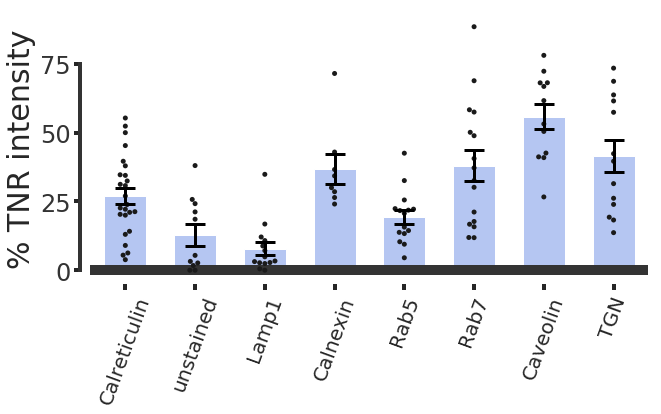

In [32]:
vari="percent ecm overlap"

sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette("Set2")
from matplotlib import ticker
plt.rcParams['font.sans-serif'] = 'Helvetica'

df2plot=df3

fig=plt.figure(figsize=(10,5))
palette={"All, mushroom": "#adadad",
         "All, flat": "#adadad",
         "New, dmso, mushroom":"#adadad",
         "New, dmso, flat":"#adadad",
        "New, bic, mushroom":"#abc2fc",
         "New, bic, flat":"#abc2fc"}

order=df2["Protein"].unique()

g=sns.barplot(data=df2plot,y=vari,x="Protein",
            color="#abc2fc",ci=None)

g=sns.swarmplot(data=df2plot,y=vari,x="Protein",
            color="k")

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        # we change the bar width
        patch.set_width(new_value)
        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)
        
change_width(g, .6)

plt.errorbar(x=np.arange(0,len(order)),
             y=[df2plot[df2plot["Protein"]==condtype][vari].mean() for condtype in order],
             yerr=[df2plot[df2plot["Protein"]==condtype][vari].sem() for condtype in order],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,
             capthick=3,zorder=10,
            alpha=1)

#plt.ylim([0,1.5])
plt.axhline(0, color='#333333',alpha=1,linewidth=10)

scale_y=1/100
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
g.yaxis.set_major_formatter(ticks_y)
#plt.yticks([0,.5,1,1.5],color='#333333')
g.xaxis.set_tick_params(width=4)
g.yaxis.set_tick_params(width=4)
plt.rcParams['font.sans-serif'] = 'Helvetica'
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":False,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=True,trim=trims,offset=offsets)
g.set_ylabel('% TNR intensity')
g.set_xlabel('',color='#333333',alpha=.7)
plt.xticks(g.get_xticks(),
           rotation=70,size=20)
plt.yticks(g.get_yticks(),size=24,color='#333333')
g.grid(False)


'''x1, x2 = 0,1
y= 1.4
h=0.02
col='black'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3.5, c=col)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=24, weight='bold')

diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'supp3_postsynpasesdio_mushstubby_alleps.svg', bbox_inches='tight', format='svg')'''